In [1]:
# Will Hagedorn
!hdfs dfs -D dfs.replication=1 -cp -f data/*.csv hdfs://nn:9000/

In [2]:
from pyspark.sql import SparkSession
spark = (SparkSession.builder.appName("cs544")
         .master("spark://boss:7077")
         .config("spark.executor.memory", "512M")
         .config("spark.sql.warehouse.dir", "hdfs://nn:9000/user/hive/warehouse")
         .enableHiveSupport()
         .getOrCreate())

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/11/04 18:57:42 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
#q1
banks_df = spark.read.option("header", True).option("inferSchema", True).csv("hdfs://nn:9000/arid2017_to_lei_xref_csv.csv")
rows = banks_df.rdd

#Lambda func
checkNames = lambda row: row["respondent_name"].split()[0] == "The"

filteredRDD = rows.filter(checkNames)
filteredRDD.count()

298

In [4]:
#q2
filteredDF = banks_df.filter("respondent_name LIKE 'The%'")
filteredDF.count()

298

In [5]:
#q3
banks_df.write.saveAsTable("banks", mode="overwrite")
filteredSQL = spark.sql("SELECT * FROM banks WHERE respondent_name LIKE 'The%'")

filteredSQL.count()

24/11/04 18:58:31 WARN HiveConf: HiveConf of name hive.stats.jdbc.timeout does not exist
24/11/04 18:58:31 WARN HiveConf: HiveConf of name hive.stats.retries.wait does not exist
24/11/04 18:58:36 WARN ObjectStore: Version information not found in metastore. hive.metastore.schema.verification is not enabled so recording the schema version 2.3.0
24/11/04 18:58:36 WARN ObjectStore: setMetaStoreSchemaVersion called but recording version is disabled: version = 2.3.0, comment = Set by MetaStore UNKNOWN@172.19.0.5
24/11/04 18:58:38 WARN ObjectStore: Failed to get database global_temp, returning NoSuchObjectException
24/11/04 18:58:43 WARN SessionState: METASTORE_FILTER_HOOK will be ignored, since hive.security.authorization.manager is set to instance of HiveAuthorizerFactory.
24/11/04 18:58:43 WARN HiveConf: HiveConf of name hive.internal.ss.authz.settings.applied.marker does not exist
24/11/04 18:58:43 WARN HiveConf: HiveConf of name hive.stats.jdbc.timeout does not exist
24/11/04 18:58:43 W

298

In [6]:
#Loans table
loans_df = spark.read.option("header", True).option("inferSchema", True).csv("hdfs://nn:9000/hdma-wi-2021.csv")
loans_df.write.bucketBy(8, "county_code").saveAsTable("loans", mode="overwrite")

#Views
views = ["ethnicity", "race", "sex", "states", "counties", "tracts", "action_taken",
 "denial_reason", "loan_type", "loan_purpose", "preapproval", "property_type"]

for view in views:
    viewDF = spark.read.option("header", True).option("inferSchema", True).csv(f"hdfs://nn:9000/{view}.csv")
    #Create view
    viewDF.createOrReplaceTempView(view)

24/11/04 18:59:02 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [7]:
#q4
tables = spark.sql("SHOW TABLES").collect()
dict = {}

for table in tables:
    dict[table["tableName"]] = table["isTemporary"]

dict

{'banks': False,
 'loans': False,
 'action_taken': True,
 'counties': True,
 'denial_reason': True,
 'ethnicity': True,
 'loan_purpose': True,
 'loan_type': True,
 'preapproval': True,
 'property_type': True,
 'race': True,
 'sex': True,
 'states': True,
 'tracts': True}

In [8]:
#q5
loansDF = spark.sql("""
          SELECT * FROM banks 
          INNER JOIN loans ON banks.lei_2020 = loans.lei 
          WHERE banks.respondent_name LIKE 'University of Wisconsin Credit Union'
          """)

loansDF.count()

19739

In [9]:
#q6
loansDF.explain("formatted")

#1. The 'banks' table is being sent to every executor via a BroadcastExchange operation. 
#   This makes sense because 'banks' is the smaller of the two tables making broadcasting it less expensive.
#2. My implementation does not involve HashAggregates, however if I had done 'COUNT(*)' within the query it would.
#   In this case their would be multiple 'COUNT' aggregates. 

== Physical Plan ==
AdaptiveSparkPlan (7)
+- BroadcastHashJoin Inner BuildLeft (6)
   :- BroadcastExchange (3)
   :  +- Filter (2)
   :     +- Scan parquet spark_catalog.default.banks (1)
   +- Filter (5)
      +- Scan parquet spark_catalog.default.loans (4)


(1) Scan parquet spark_catalog.default.banks
Output [5]: [respondent_name#64, arid_2017#65, lei_2018#66, lei_2019#67, lei_2020#68]
Batched: true
Location: InMemoryFileIndex [hdfs://nn:9000/user/hive/warehouse/banks]
PushedFilters: [IsNotNull(respondent_name), EqualTo(respondent_name,University of Wisconsin Credit Union), IsNotNull(lei_2020)]
ReadSchema: struct<respondent_name:string,arid_2017:string,lei_2018:string,lei_2019:string,lei_2020:string>

(2) Filter
Input [5]: [respondent_name#64, arid_2017#65, lei_2018#66, lei_2019#67, lei_2020#68]
Condition : ((isnotnull(respondent_name#64) AND (respondent_name#64 = University of Wisconsin Credit Union)) AND isnotnull(lei_2020#68))

(3) BroadcastExchange
Input [5]: [respondent_name#64

In [10]:
#q7

import pandas as pd

banksTable = spark.table("banks")
loansTable = spark.table("loans")
countiesTable = spark.table("counties")

avgRates = (
    banksTable
    .join(loansTable, how="inner", on=(banksTable["lei_2020"] == loansTable["lei"]))
    .filter(banksTable["respondent_name"] == "Wells Fargo Bank, National Association")
    .join(countiesTable, how="inner", on=(loansTable["county_code"] == countiesTable["STATE"]*1000 + countiesTable["COUNTY"]))
    .select("respondent_name", "activity_year", "NAME", "loan_amount", "interest_rate")
    .groupBy("NAME")
    .agg({"interest_rate" : "mean"})
)

topTen = (
    banksTable
    .join(loansTable, how="inner", on=(banksTable["lei_2020"] == loansTable["lei"]))
    .filter(banksTable["respondent_name"] == "Wells Fargo Bank, National Association")
    .join(countiesTable, how="inner", on=(loansTable["county_code"] == countiesTable["STATE"]*1000 + countiesTable["COUNTY"]))
    .groupBy("NAME")
    .count()
    .orderBy("count", ascending=False)
    .limit(10)
    .select("NAME", "count")
)

countyRates = (
    topTen
    .join(avgRates, how="left", on=(avgRates["NAME"] == topTen["NAME"]))
    .orderBy("count", ascending=False)
    .collect()
)

#Put in a Dict
dict = {}

for row in countyRates:
    dict[row["NAME"]] = row["avg(interest_rate)"]

dict

{'Milwaukee': 3.1173465727097907,
 'Waukesha': 2.8758225602027756,
 'Washington': 2.851009389671362,
 'Dane': 2.890674955595027,
 'Brown': 3.010949119373777,
 'Racine': 3.099783715012723,
 'Outagamie': 2.979661835748792,
 'Winnebago': 3.0284761904761908,
 'Ozaukee': 2.8673765432098772,
 'Sheboygan': 2.995511111111111}

<Axes: xlabel='name', ylabel='Average Interest Rate'>

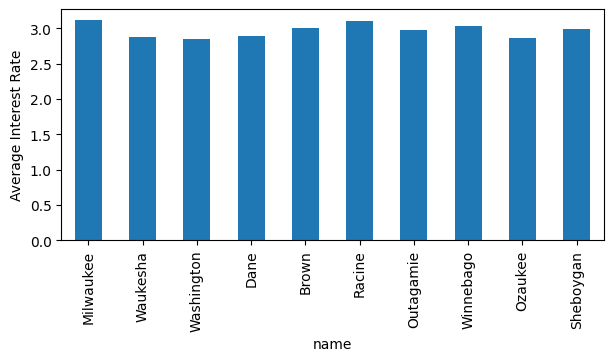

In [11]:
#Plot data
pandas_df = pd.DataFrame(list(dict.items()), columns=["county", "avg interest"]) 
ax = (pandas_df.set_index("county")["avg interest"]).plot.bar(figsize=(7,3))
ax.set_ylabel("Average Interest Rate")
ax.set_xlabel("name")

ax

In [12]:
#q8

#Group by county_code
spark.sql("""
    SELECT county_code, mean(interest_rate) 
    FROM loans
    GROUP BY county_code
    """).explain()

#Group by lei
spark.sql("""
    SELECT lei, mean(interest_rate)
    FROM loans
    GROUP BY lei
    """).explain()

#1. Grouping by county_code did not require network I/O, but grouping by lei did. 
#   This is because when writing the loans table we created 8 buckets on county_code.
#   This means rows with the same county_code will be in the same bucket, allowing Spark to avoid exchanging during the GroupBy.

== Physical Plan ==
AdaptiveSparkPlan isFinalPlan=false
+- HashAggregate(keys=[county_code#1000], functions=[mean(cast(interest_rate#1019 as double))])
   +- HashAggregate(keys=[county_code#1000], functions=[partial_mean(cast(interest_rate#1019 as double))])
      +- FileScan parquet spark_catalog.default.loans[county_code#1000,interest_rate#1019] Batched: true, Bucketed: true, DataFilters: [], Format: Parquet, Location: InMemoryFileIndex(1 paths)[hdfs://nn:9000/user/hive/warehouse/loans], PartitionFilters: [], PushedFilters: [], ReadSchema: struct<county_code:string,interest_rate:string>, SelectedBucketsCount: 8 out of 8


== Physical Plan ==
AdaptiveSparkPlan isFinalPlan=false
+- HashAggregate(keys=[lei#997], functions=[mean(cast(interest_rate#1019 as double))])
   +- Exchange hashpartitioning(lei#997, 200), ENSURE_REQUIREMENTS, [plan_id=1544]
      +- HashAggregate(keys=[lei#997], functions=[partial_mean(cast(interest_rate#1019 as double))])
         +- FileScan parquet spark_catalo

In [13]:

mldf = spark.sql("""
    SELECT CAST(loan_amount AS DOUBLE), CAST(income AS DOUBLE), CAST(interest_rate AS DOUBLE),
        CASE WHEN action_taken.action_taken = 'Loan originated' THEN 1.0 ELSE 0.0 END AS approval
    FROM loans
    JOIN action_taken ON action_taken.id = loans.action_taken
    """)

mldf = mldf.na.fill(0.0)

# deterministic split
train, test = mldf.randomSplit([0.8, 0.2], seed=41) 
train.cache()

DataFrame[loan_amount: double, income: double, interest_rate: double, approval: decimal(2,1)]

In [14]:
#q9

from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.pipeline import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

accuracy = MulticlassClassificationEvaluator(metricName = "accuracy", labelCol = "approval", predictionCol = "prediction")
va = VectorAssembler(inputCols=["loan_amount", "income", "interest_rate"], outputCol="features")

depths = [1, 5, 10, 15, 20]
dict = {}

for depth in depths:
    dt = DecisionTreeClassifier(featuresCol = "features", labelCol = "approval", maxDepth = depth, seed = 41)
    pipe = Pipeline(stages = [va, dt])

    model = pipe.fit(train)
    preds = model.transform(test)

    dict[f'depth={depth}'] = accuracy.evaluate(preds)

dict

24/11/04 19:03:23 WARN DAGScheduler: Broadcasting large task binary with size 1086.7 KiB
24/11/04 19:03:25 WARN DAGScheduler: Broadcasting large task binary with size 1379.0 KiB
24/11/04 19:03:27 WARN DAGScheduler: Broadcasting large task binary with size 1699.8 KiB
24/11/04 19:03:29 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
24/11/04 19:03:31 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


{'depth=1': 0.8809425750509244,
 'depth=5': 0.8929195560947918,
 'depth=10': 0.8954796914480349,
 'depth=15': 0.8948674851679115,
 'depth=20': 0.893943610236089}

In [15]:
#q10
#1. Test accuracy does not always increase with a larger max-depth value. 
#   When the max-depth is too high the model runs the risk of overfitting and 'memorizing' the training data.
#   This means the model doesn't learn the patterns of the data and generalizes poorly to unseen test data.
#   This can cause a plateua or decrease in model accuracy.